In [2]:
import cv2
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray,rgb2hsv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median, gaussian
from skimage.feature import canny

# Edges
from skimage.filters import sobel_h, sobel, sobel_v,roberts, prewitt


## Read video

In [3]:
vidcap = cv2.VideoCapture('images/LaneVideo.mp4')
success, image = vidcap.read()

In [4]:
# # Read and display frames
# while vidcap.isOpened():
#     ret, frame = vidcap.read()  # Read a frame
#     if ret:
#         cv2.imshow('Frame', frame)  # Display the frame
#         if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit
#             break
#     else:
#         break

# # Release the capture when done
# cap.release()
# cv2.destroyAllWindows()


In [5]:
def plot_images(img1, img2, label1="Origianl Image", label2 = "Cropped Image"):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the first image on the first subplot
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(label1)

    # Plot the second image on the second subplot
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(label2)

    # Show the plot
    plt.tight_layout()
    plt.show()

## Crop Image

In [6]:
# Crop image function 
def ROI(img):
#     img = io.imread(path)
    d_row, d_col, _ = img.shape
    
    roi_maxr = d_row // 2
    roi_maxc = d_col // 2
    print(d_row, roi_maxr)
    img_arr = np.array(img)
    if d_row >= 500:
        cropped_img = img_arr[(roi_maxr + 100):d_row,:]
    elif d_row > 350:
        cropped_img = img_arr[(roi_maxr + 40):d_row,:]
    
    if d_col > 1000:
        cropped_img = img_arr[roi_maxr+120:d_row, 300:900]
    return cropped_img


In [7]:
cropped_img = ROI(image)

720 360


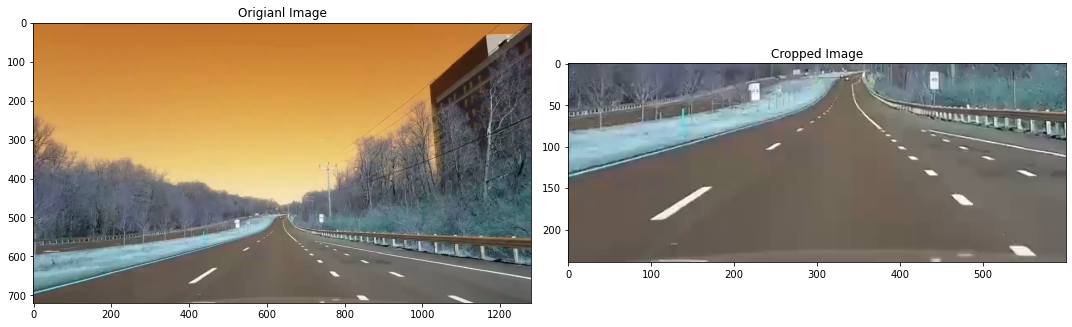

In [8]:
plot_images(image, cropped_img)

## Convert to Gray & Smoothing

In [9]:
def smooth(image):
    gray_image = rgb2gray(image)
    f_image = median(gray_image)
    return f_image

In [10]:
s_image = smooth(cropped_img)

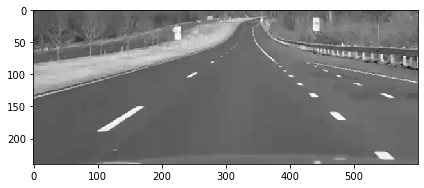

In [11]:
io.imshow(s_image)
plt.show()

## Histogram

In [12]:
def histogram_equalization(img):
    # Load image using io.imread()
#     img = io.imread(image_path)

    # Compute histogram
    hist, bins = np.histogram(img.flatten(), bins=256)

    # Compute cumulative distribution function (CDF)
    cdf = hist.cumsum()
    cdf_normalized = (cdf * hist.max()) / cdf.max()

    # Perform histogram equalization
    equalized_img = np.interp(img.flatten(), bins[:-1], cdf_normalized).reshape(img.shape)

    # ** normalize image pixel values
    min_value = np.min(equalized_img)
    max_value = np.max(equalized_img)
    # print(equalized_img, min_value, max_value)
    image_normalized = (equalized_img - min_value) / (max_value - min_value)
    
    return image_normalized

In [13]:
equalized_img = histogram_equalization(s_image)

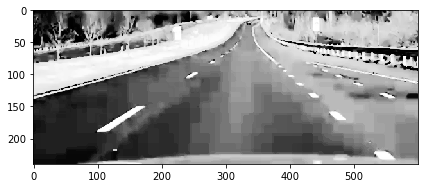

In [14]:
io.imshow(equalized_img, cmap='gray')
plt.show()

## Canny

In [15]:
def apply_filter(img, f):
    img_in_freq = fftpack.fft2(img)
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)
    filtered_img = fftpack.ifft2(filtered_img_in_freq)
    return filtered_img

In [16]:
def canny_edge_detection(image, sigma=2.0, low_threshold=50, high_threshold=150):
    # Convert the image to grayscale
#     gray_image = rgb2gray(image)  # modified
    
    # Apply Gaussian smoothing to reduce noise
    smoothed_image = gaussian(image, sigma)
    
    # ** Add low pass filter
    f=np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
            ])
    
    smoothed_image = np.abs(apply_filter(smoothed_image, f))
    print(smoothed_image)
    # Compute gradients using Sobel filters
    gradient_x = np.gradient(smoothed_image, axis=1)
    gradient_y = np.gradient(smoothed_image, axis=0)

    # Compute gradient magnitude and direction
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x)
    
    # Apply non-maximum suppression to thin the edges
    suppressed_image = np.zeros_like(gradient_magnitude)

    for i in range(1, gradient_magnitude.shape[0] - 1):
        for j in range(1, gradient_magnitude.shape[1] - 1):
            angle = gradient_direction[i, j]
            if (0 <= angle < np.pi/8) or (7*np.pi/8 <= angle <= np.pi):
                q = gradient_magnitude[i, j+1]
                r = gradient_magnitude[i, j-1]
            elif (np.pi/8 <= angle < 3*np.pi/8):
                q = gradient_magnitude[i+1, j-1]
                r = gradient_magnitude[i-1, j+1]
            elif (3*np.pi/8 <= angle < 5*np.pi/8):
                q = gradient_magnitude[i+1, j]
                r = gradient_magnitude[i-1, j]
            else:
                q = gradient_magnitude[i-1, j-1]
                r = gradient_magnitude[i+1, j+1]
            if gradient_magnitude[i, j] >= q and gradient_magnitude[i, j] >= r:
                suppressed_image[i, j] = gradient_magnitude[i, j]
    
    suppressed_image = suppressed_image * 255  # modified
    
    # Apply hysteresis thresholding to detect edges
    edges = np.zeros_like(suppressed_image)
    strong_edges = suppressed_image > high_threshold
    edges[strong_edges] = 255
    
    weak_edges = (suppressed_image >= low_threshold) & (suppressed_image <= high_threshold)
    max_iter = 50 # modified
    while (np.sum(weak_edges) > 0 and max_iter > 0): # modified
        max_iter -= 1
        weak_edges_coords = np.argwhere(weak_edges)
        i, j = weak_edges_coords[0]
        edges[i, j] = 255
        weak_edges[i, j] = False
        neighbors = weak_edges[max(0, i-1):min(i+2, weak_edges.shape[0]), max(0, j-1):min(j+2, weak_edges.shape[1])]
        if np.sum(neighbors) > 0:
            weak_edges[np.where(neighbors)] = True

    return edges

In [17]:
%time edged_image = canny(s_image, 1.1, 0.3, 0.9).astype(int).astype(float) # image with no equalization

Wall time: 61.8 ms


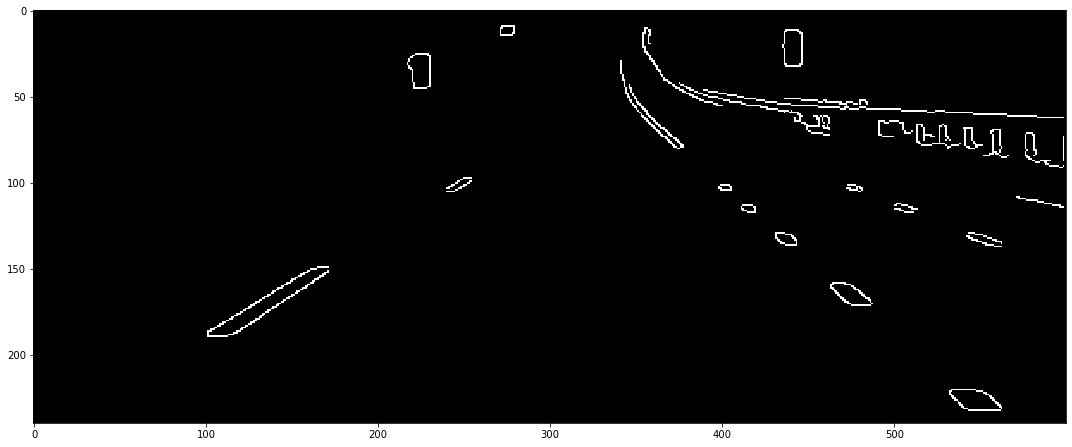

In [18]:
plt.figure(figsize=(15, 10))  # Define the figure size (width, height)
io.imshow(edged_image, cmap='gray')
plt.show()

## Prespective Transformation

In [35]:
#corner Points (needs to be put manualy)

def prespective_transformation(img):
    # frame = cv2.resize(img,(640,480), interpolation=cv2.INTER_NEAREST)
    frame = img
    tl= (250, 50) #Top Left
    bl=(0, 240)   #Bottom Left
    tr=(350, 50)  #Top Right
    br=(580,240)  #Bottom Right
    
    cv2.circle(frame, tl, 5 , (0, 0, 255),-1)
    cv2.circle(frame, bl, 5 , (0,0,255),-1)
    cv2.circle(frame, tr, 5 , (0,0,255),-1)
    cv2.circle(frame, br, 5 , (0,0,255),-1)

    pt1=np.float32([tl,bl,tr,br])                       #Source Points
    pt2=np.float32([[0,0],[0,480],[640,0],[640,480]])   #Destination Points

    #Perspective Transformation
    matrix= (cv2.getPerspectiveTransform(pt1,pt2)) 
    transformed_frame= cv2.warpPerspective(frame, matrix,(640,480))

    #Inverse Perspective Transformation
    matrix2= np.linalg.inv(matrix)
    inverted_transformed_frame= cv2.warpPerspective(transformed_frame,matrix2,(640,480))
    return transformed_frame, inverted_transformed_frame, frame



In [36]:
t_frame, it_frame, frame = prespective_transformation(edged_image)

In [ ]:
cv2.imshow("transformed frame",t_frame)
cv2.imshow("Frame", frame)
cv2.imshow("inverted tranformation",it_frame)
cv2.waitKey(0)